In [ ]:
# default_exp subcoco_frcnn_lightning

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Exploring Object Detection using Pytorch Lightning Only

Instead of using higher level library such as IceVision, I am gonna try using what's in Torch Vision, see [example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

To force some learning, I shall attempt to port the example to [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning) as it removes a lot of boiler plate code and standardized Pytorch usage. It also makes advanced features like gradient accumulation and multi-GPU multi-node training simple.

In [ ]:
#export
import cv2, json, os, requests, sys, tarfile, torch, torchvision
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pickle
import random
import torch.nn.functional as F
import torch.multiprocessing

from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from functools import reduce
from IPython.utils import io
from pathlib import Path
from PIL import Image
from PIL import ImageStat

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision.datasets import CocoDetection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm
from typing import Hashable, List, Tuple, Union

torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
#hide

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    os.chdir('/content/drive/My Drive/ColabData')
    print(f'Current Directory is now {os.getcwd()}')
    !wget -O 'mcbbox/subcoco_utils.py' https://raw.githubusercontent.com/bguan/mcbbox/master/mcbbox/subcoco_utils.py
    !pip install pytorch_lightning torchvision gpumonitor
else:
    from nbdev.showdoc import *


In [ ]:
#export
import pytorch_lightning as pl
from gpumonitor.monitor import GPUStatMonitor
from gpumonitor.callbacks.lightning import PyTorchGpuMonitorCallback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.core.step_result import TrainResult
from mcbbox.subcoco_utils import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, pytorch_lightning {pl.__version__}, Albumentation {A.__version__}")
if torch.cuda.is_available(): monitor = GPUStatMonitor(delay=1)

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.6.0, torchvision 0.7.0, pytorch_lightning 1.0.4, Albumentation 0.4.6


# Setup the Run

Centralize test run vs prod time parameters

In [ ]:
#hide
test = True
if test:
    img_sz, bs, acc, workers, head_runs, full_runs = 128, 4, 8, 1, 1, 1
    datadir, url, img_subdir = '/tmp', 'http://files.fast.ai/data/examples/coco_tiny.tgz', 'train'
else:
    img_sz, bs, acc, workers, head_runs, full_runs = 384, 6, 6, 4, 5, 20
    datadir, url, img_subdir = 'workspace', 'https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz', 'train_sample'
    
stem = Path(url).stem
img_dir=f'{datadir}/{stem}/{img_subdir}'

/home/brian/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

In [ ]:
#hide
train_json = fetch_subcoco(datadir=datadir, url=url, img_subdir=img_subdir)

## Check Annotations

Let's load and inspect the annotation file that comes with the coco tiny dataset...

In [ ]:
#hide
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 542959, 'file_name': '000000542959.jpg'},
 [{'image_id': 542959, 'bbox': [32.52, 86.34, 8.53, 9.41], 'category_id': 62},
  {'image_id': 542959, 'bbox': [98.12, 110.52, 1.95, 4.07], 'category_id': 86},
  {'image_id': 542959, 'bbox': [91.28, 51.62, 3.95, 5.72], 'category_id': 86},
  {'image_id': 542959,
   'bbox': [110.48, 110.82, 14.55, 15.22],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [96.63, 50.18, 18.67, 13.46],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [0.69, 111.73, 11.8, 13.06],
   'category_id': 62}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image... Print out number of boxes per category to see if the distribution is not too unbalanced...

In [ ]:
#hide
stats = load_stats(train_json, img_dir=img_dir, force_reload=False)
print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, avg (w,h) {(stats.avg_width, stats.avg_height)}"
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")
{ stats.cat2name[stats.lbl2cat[lid]]: len(ibs) for lid, ibs in stats.l2ibs.items()}

Categories 6, Images 200, Boxes 688, avg (w,h) (128.0, 128.0)avg cats/img 7.0, avg boxs/img 3.4, avg boxs/cat 114.7.
Image means by channel [126.2909314  109.02263367 100.61073242], std.dev by channel [65.60744282 65.09696176 60.4631069 ]


{'chair': 284, 'vase': 64, 'tv': 26, 'couch': 40, 'book': 254, 'remote': 20}

Hmm, seems like a lot of chairs and books, but vases, tvs, couches and remotes are roughly 10x less. This may be a problem. 
But we have enough to test drive the training pipeline. To make it more balanced, may be I can combine vase+tv+couch+remote into a new category 'others' later?

## Look at Images

Let's look at an image annotation.

In [ ]:
best_img_pos = None
max_boxs = 0
for img_pos in range(len(train_json['images'])):  
    img_id = train_json['images'][img_pos]['id']
    l2bs = stats.img2l2bs.get(img_id, {})
    n_boxs =  reduce((lambda x, y: x + y), [1 if len(bs) > 0 else 0 for bs in l2bs.values()], 0)
    if n_boxs >= max_boxs:
        best_img_pos = img_pos
        max_boxs = n_boxs

print(f'best_img_pos {best_img_pos}')
best_img_id = train_json['images'][best_img_pos]['id']
l2bs = stats.img2l2bs[best_img_id]
best_img_fname = stats.img2fname[best_img_id]
best_img_id, best_img_fname, l2bs

best_img_pos 89


(107903,
 '000000107903.jpg',
 {0: [],
  1: [(90.86, 85.09, 33.16, 38.46)],
  2: [(81.75, 56.7, 42.12, 31.66), (91.19, 85.84, 33.11, 37.77)],
  3: [(31.67, 36.95, 29.82, 24.54)],
  4: [],
  5: [(70.08, 91.25, 9.82, 5.1),
   (67.28, 77.63, 16.32, 5.83),
   (37.7, 76.38, 1.16, 4.6),
   (5.12, 73.58, 3.41, 8.88),
   (115.35, 75.7, 8.47, 2.68),
   (69.76, 93.02, 9.79, 6.08),
   (64.86, 87.24, 9.3, 4.97),
   (8.36, 63.94, 1.09, 6.74),
   (115.74, 74.44, 8.03, 3.33),
   (77.48, 91.77, 6.14, 2.82),
   (8.33, 73.88, 1.55, 8.13)],
  6: [(6.2, 42.53, 3.48, 3.95)]})

## Overlay Boxes and Labels from Annotation

Let's overlay bounding boxes and labels over the image to confirm our understanding of the data.
Pick some random image to test drive the box overlay code...

img = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128 at 0x7F11049A7340>


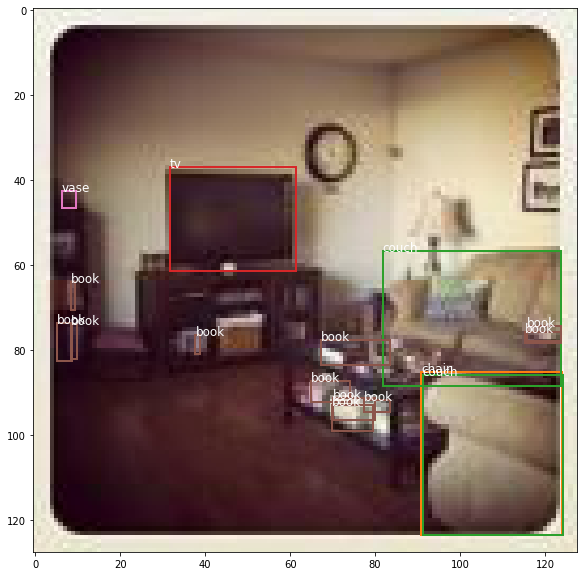

In [ ]:
img = Image.open(Path(img_dir)/stats.img2fname[best_img_id])
print(f"img = {img}")
overlay_img_bbox(img, stats.img2l2bs[best_img_id], stats.lbl2name)

## Wrap Data Loading Logic using Pytorch-Lightning

In order to use Pytorch Lightning to load data, we need to define a DataModule to encapsulate all the data loading logic. At first I thought I can reuse CocoDetect() from torchvision but it uses cocoapi downstream and expects json annotation file to be of this [format](https://cocodataset.org/#format-data):
```
annotation{
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}
```

Tiny and Sample Coco's train.json file only has a subset of the above fields:
```
“Annotations”: [
    {
      "image_id": 542959,
      "bbox": [
        32.52,
        86.34,
        8.53,
        9.41
      ],
      "category_id": 62
    },
    ...
]
``` 

Thus we will need to make a Dataset to handle it properly.

In [ ]:
# export
class SubCocoDataset(torchvision.datasets.VisionDataset):
    """
    Simulate what torchvision.CocoDetect() returns for target given fastai's coco subsets
    Args:
        root (string): Root directory where images are downloaded to.
        stats (CocoDatasetStats):
    """

    def __init__(self, root:str, stats:CocoDatasetStats, img_ids:list=[], bbox_aware_tfms:callable=None):
        super(SubCocoDataset, self).__init__(root) 
        self.stats = stats
        self.img_ids = []
        n_missing = 0
        for img_id in img_ids:
            img_fname = stats.img2fname[img_id]
            if not os.path.isfile(stats.img_dir/img_fname):
                n_missing += 1
            elif stats.img2sz.get(img_id, None) is None:
                n_missing += 1
            else:
                self.img_ids.append(img_id)
        if n_missing > 0 : print(f'Warning: {n_missing} image files are missing!!!')
        self.bbox_aware_tfms = bbox_aware_tfms

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        img_id = self.img_ids[index] if index < len(self.img_ids) else 0
        img_fname = self.stats.img2fname.get(img_id, None)
        if img_id is None or img_fname ==None:
            return (None, None)
        img_fpath = os.path.join(self.root, img_fname)
        img_w, img_h = self.stats.img2sz.get(img_id, (1,1))
        target = { 'boxes': [], 'labels': [], 'image_id': img_id, 'width': img_h, 'height': img_h, 'areas': [], 'iscrowds': 0, 'ids': [] }
        count = 0
        lbs = self.stats.img2lbs.get(img_id,[])
        for l, x, y, w, h in lbs:
            count += 1
            target['boxes'].append([x, y, x+w, y+h]) # FRCNN wants x1,y1,x2,y2 format!
            target['labels'].append(l)
            target['areas'].append(w*h)
            anno_id = img_id*1000 + count
            target['ids'].append(anno_id)

        img = cv2.imread(img_fpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.bbox_aware_tfms is not None:
            transformed = self.bbox_aware_tfms(image=img, bboxes=target['boxes'], class_labels=target['labels'])
            img = transformed['image']
            target['boxes'] = transformed['bboxes']

        for k, v in target.items():
            target[k] = torch.tensor(v, dtype=(torch.float if k in ['boxes', 'width', 'height', 'areas'] else torch.long))
        
        img = torch.from_numpy(img/255.0).float().permute(2, 0, 1)
        return img, target

    def __len__(self):
        return len(self.img_ids)

It is standard to do some transformation when preparing image data.  I shall use Albumentation for it. For now let's just verify the basics works...

img =
tensor([[[0.9765, 0.9451, 0.9373,  ..., 0.9373, 0.9647, 0.8980],
         [0.9451, 0.9373, 0.9098,  ..., 0.9216, 0.9255, 0.9255],
         [0.9098, 0.9725, 0.9373,  ..., 0.9412, 0.9294, 0.9333],
         ...,
         [0.8902, 0.9608, 0.9255,  ..., 0.9333, 0.9647, 0.8980],
         [0.9216, 0.9216, 0.9020,  ..., 0.8941, 0.9176, 0.9255],
         [0.9569, 0.9294, 0.9294,  ..., 0.9059, 0.9176, 0.9569]],

        [[0.9647, 0.9333, 0.9373,  ..., 0.9529, 0.9804, 0.9137],
         [0.9333, 0.9255, 0.9098,  ..., 0.9373, 0.9412, 0.9412],
         [0.9098, 0.9725, 0.9373,  ..., 0.9569, 0.9451, 0.9569],
         ...,
         [0.8627, 0.9333, 0.8980,  ..., 0.9098, 0.9412, 0.8745],
         [0.8902, 0.8902, 0.8784,  ..., 0.8706, 0.8863, 0.8980],
         [0.9255, 0.8980, 0.9059,  ..., 0.8824, 0.8902, 0.9294]],

        [[0.9294, 0.8980, 0.8902,  ..., 0.8980, 0.9216, 0.8549],
         [0.8980, 0.8902, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         [0.8627, 0.9255, 0.8902,  ..., 0.9020, 0.89

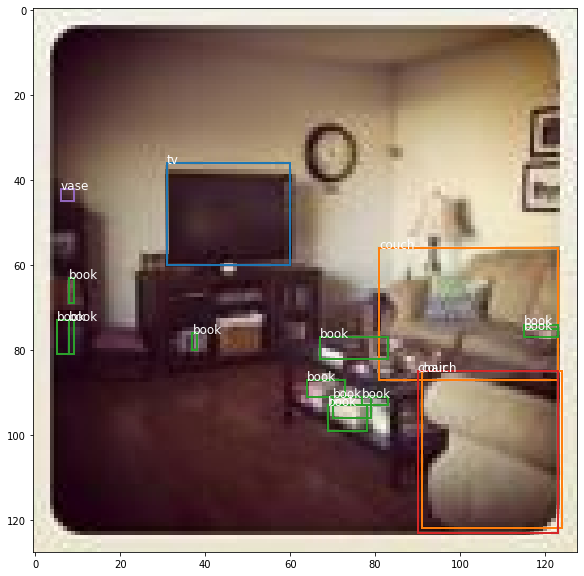

In [ ]:
#hide
dataset = SubCocoDataset(img_dir, stats, img_ids=list(stats.img2sz.keys()))
img,tgt = dataset[best_img_pos]
print(f"img =\n{img}\ntgt =\n{tgt}")
tgt_l2bs = defaultdict(empty_list)
n_boxs = 0
for l, b in zip(list(tgt['labels']), tgt['boxes']):
    n_boxs +=1
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

print(f"n_boxs = {n_boxs}")
pimg = torchvision.transforms.ToPILImage()(img)
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

Verify the image transformation works using Albumentation, especially random transform to both image and target

n_boxs = 16


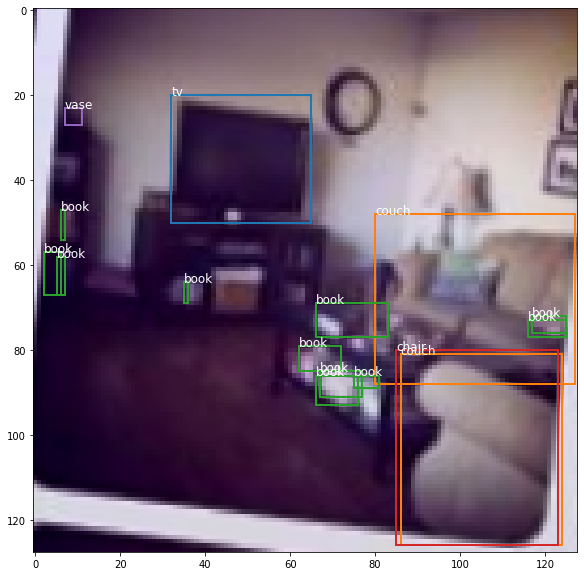

In [ ]:
#hide
tfms = A.Compose([
    A.ShiftScaleRotate(shift_limit=.025, scale_limit=0.025, rotate_limit=9),
    A.RandomSizedBBoxSafeCrop(width=128,height=128),
    A.HorizontalFlip(p=0.5), 
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.Blur(blur_limit=(1, 3)),
    #A.Normalize(), #mean=stats.chn_means/255, std = stats.chn_stds/255), #why is this fucked up?
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

dataset = SubCocoDataset(img_dir, stats, img_ids=list(stats.img2sz.keys()), bbox_aware_tfms=tfms) 
img, tgt = dataset[best_img_pos]
tgt_l2bs = defaultdict(empty_list)
n_boxs = 0
for l, b in zip(list(tgt['labels']), tgt['boxes']):
    n_boxs +=1
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

print(f"n_boxs = {n_boxs}")
pimg = torchvision.transforms.ToPILImage()(img)
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

## Custom DataModule

In [ ]:
#export
class SubCocoDataModule(LightningDataModule):

    def __init__(self, root, stats, bs=32, workers=4, split_ratio=0.8, shuffle=True, 
                 train_transforms=None, val_transforms=None):
        super().__init__(train_transforms=train_transforms, val_transforms=val_transforms)
        self.dir = root
        self.bs = bs
        self.workers = workers
        self.stats = stats
        self.split_ratio = split_ratio
        self.shuffle = shuffle

        num_items = stats.num_imgs
        num_train = int(self.split_ratio*num_items)
        img_ids = list(stats.img2sz.keys())
        if shuffle: random.shuffle(img_ids)
            
        train_img_ids = img_ids[:num_train]
        val_img_ids = img_ids[num_train:]
        
        self.train = SubCocoDataset(self.dir, self.stats, img_ids=train_img_ids, bbox_aware_tfms=train_transforms) 
        self.val = SubCocoDataset(self.dir, self.stats, img_ids=val_img_ids, bbox_aware_tfms=val_transforms) 

    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn, shuffle=False)

In [ ]:
#hide
tiny_coco_dm = SubCocoDataModule(img_dir, stats, bs=2, train_transforms=tfms, val_transforms=tfms)
tdl=tiny_coco_dm.train_dataloader()
images, targets = next(iter(tdl))

len(images), len(targets), images[0], targets[0]

(2,
 2,
 tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.8588, 0.8353, 0.8039,  ..., 0.6706, 0.6431, 0.6196],
          [0.9020, 0.8784, 0.8431,  ..., 0.6471, 0.6196, 0.6000],
          [0.9333, 0.9098, 0.8824,  ..., 0.6275, 0.6039, 0.5882]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9333, 0.9098, 0.8745,  ..., 0.7451, 0.7137, 0.6902],
          [0.9765, 0.9529, 0.9176,  ..., 0.7176, 0.6902, 0.6706],
          [1.0000, 0.9843, 0.9569,  ..., 0.6980, 0.6745, 0.6588]],
 
         [[0.9882, 0.9882, 0.9882,  ..., 0.9961, 0.9922, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.9961, 0.9961, 0.9961],
          [0.9922, 0.9922, 0.992

## Packaging Model and Metric Into A Lightning Module

In [ ]:
# export
class FRCNN(LightningModule):
    
    def __init__(self, lbl2name:dict={}, img_sz=128, lr:float=1e-3):
        LightningModule.__init__(self)
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        # get number of input features of classifier
        self.in_features = self.model.roi_heads.box_predictor.cls_score.in_features

        #refit another head
        self.categories = [ {'id': l, 'name': n } for l, n in lbl2name.items() ]
        self.num_classes = len(self.categories)
        # replace the pre-trained head with a new one, which is trainable
        self.model.roi_heads.box_predictor = FastRCNNPredictor(self.in_features, self.num_classes+1)
        self.img_sz = img_sz
        self.lr = lr
        
        # Hacked to avoid model builtin call to GeneralizedRCNNTransform.normalize() as done in augmentation
        def noop_normalize(image): return image 

        # Hacked to avoid model builtin call to GeneralizedRCNNTransform.resize() as done in augmentation
        def noop_resize(image, target): return image, target  

        # HACK!! IceVision does this too!
        self.model.transform.normalize = noop_normalize
        self.model.transform.resize = noop_resize
        
        self.freeze()
        self.unfreeze_head()
        
    def freeze_head(self):
        for param in self.model.roi_heads.parameters(): param.requires_grad = False
        
    def unfreeze_head(self):
        for param in self.model.roi_heads.parameters(): param.requires_grad = True
        
    def freeze(self):
        for param in self.model.parameters(): param.requires_grad = False
        
    def unfreeze(self):
        for param in self.model.parameters(): param.requires_grad = True
        
    # FRCNN is tricky, in training model the model takes X & Y to produce loss
    def training_step(self, train_batch, batch_idx):
#         print('Entering training_step')
        self.model.cuda()
        self.model.train()
        xs, ys = train_batch
        losses = self.model.forward(xs, ys)
        # has 4 types of losses: loss_classifier loss_box_reg loss_objectness loss_rpn_box_reg
        loss = sum(losses.values())
#         print(f'Exiting training_step, returning {loss}')
        return loss 

    def metrics(self, preds, targets):
        metrics = torch.zeros((min(len(preds), len(targets)), 2))
        for i, (p,t) in enumerate(zip(preds, targets)):
            metrics[i,0] = calc_wavg_F1(p, t, .5, .5)
            metrics[i,1] = SubCocoWrapper(p, t, self.img_sz, self.img_sz).metrics()[0]
        return metrics

    def validation_step(self, val_batch, batch_idx):
#         print('Entering validation_step')
        self.model.cpu()
        self.model.eval()

        # turn off auto gradient for validation step
        with torch.no_grad():
            xs, ys = val_batch
            xs_cpu = [ x.cpu() for x in xs ]
            ys_cpu = [ { k:v.cpu() for k,v in y.items() } for y in ys ]
            preds = self.model(xs_cpu)
            metrics = self.metrics(preds, ys)

            self.model.train()
            losses = self.model(xs_cpu, ys_cpu)
        
        result = {'val_acc': metrics[:,0], 'val_coco': metrics[:,1], 'val_loss': sum(losses.values())} 
#         print(f'Exiting validation_step, returning {result}')
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def validation_epoch_end(self, outputs):
        tensorboard_logs ={}
        # called at the end of the validation epoch, but gradient accumulation may result in last row being different size
        val_accs = np.concatenate([ (o['val_acc']).numpy() for o in outputs ])
        avg_acc = val_accs.mean()
        tensorboard_logs['val_acc'] = avg_acc
        
        val_cocos = np.concatenate([ (o['val_coco']).numpy() for o in outputs ])
        avg_coco = val_cocos.mean()
        tensorboard_logs['val_coco'] = avg_coco
        
        val_losses = np.array([ float(o['val_loss']) for o in outputs ])
        avg_loss = val_losses.mean()
        tensorboard_logs['val_loss'] = avg_loss
        print(f"Epoch end avg val_acc = {avg_acc} (F1 @ IoU>.5, Score>.5), avg val_coco = {avg_coco}, avg val_loss = {avg_loss}")
        self.log_dict({'val_acc': avg_acc, 'val_coco': avg_coco, 'val_loss': avg_loss, 'logs': tensorboard_logs})

    # forward takes only X, so need to put FRCNN in eval mode
    def forward(self, xs):
        self.model.eval()
        return self.model(xs)

## Neural Network Architecture Model

On my Dell XPS15 GTX-1050 GPU w/ 4GB VRAM,  I can average 1 epoc every 120 min or so, at bs=2 acc=16, img 384x384, with unfrozen backbone.

Using my GCP w/ V100 of 16GB VRAM, I can fit bs=12 for sample_coco, acc=16, img 384x384, with unfrozen backbone, 1 epoc every ~25 minutes.

In [ ]:
#export
def run_training(stats:CocoDatasetStats, modeldir:str, img_dir:str, resume_ckpt_fname:str=None, 
                 img_sz=384, bs=12, acc=4, workers=4, head_runs=50, full_runs=200,
                 monitor='val_acc', mode='max', save_top=-1,
                ):
    
    frcnn_model = FRCNN(lbl2name=stats.lbl2name, img_sz=img_sz)

    print(f"Training with image size {img_sz}, auto learning rate, for {head_runs}+{full_runs} epochs.")
    chkpt_cb = ModelCheckpoint(
        filename='FRCNN-subcoco-'+str(img_sz)+'-{epoch:03d}-{'+monitor+':.3f}',
        dirpath=modeldir,
        save_last=True,
        monitor=monitor,
        mode=mode,
        save_top_k=save_top,
        verbose=True,
    )
    early_stop_cb = EarlyStopping(
       monitor=monitor,
       min_delta=0.001,
       patience=5,
       verbose=True,
       mode=mode
    )
    gpumon_cb = PyTorchGpuMonitorCallback(delay=1)
    callbacks = [early_stop_cb, gpumon_cb]
    resume_ckpt = f'{modeldir}/{resume_ckpt_fname}' if resume_ckpt_fname != None else None
    if resume_ckpt and os.path.isfile(resume_ckpt):
        try:
            print(f'Loading previously saved model: {resume_ckpt}...')
            frcnn_model = FRCNN.load_from_checkpoint(resume_ckpt, lbl2name=stats.lbl2name)
        except Exception as e:
            print(f'Unexpected error loading previously saved model {resume_ckpt}: {e}')
    elif resume_ckpt:
        print(f'Failed to find {resume_ckpt}')
    
    # transforms for images
    bbox_aware_train_tfms=A.Compose([
        A.ShiftScaleRotate(shift_limit=.025, scale_limit=0.025, rotate_limit=9),
        A.Resize(width=img_sz, height=img_sz),
        A.HorizontalFlip(p=0.5), 
        A.RGBShift(),
        A.RandomBrightnessContrast(),
        A.Blur(blur_limit=(1, 3)),
        #A.Normalize(), #mean=stats.chn_means/255, std=stats.chn_stds/255)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    bbox_aware_val_tfms=A.Compose([
        A.Resize(width=img_sz, height=img_sz),
        #A.Normalize(), #mean=stats.chn_means/255, std=stats.chn_stds/255)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    # train head only, since using less params, double the bs and half the grad accumulation cycle to use more GPU VRAM
    if head_runs > 0:
        head_dm = SubCocoDataModule(img_dir, stats, 
                                    train_transforms=bbox_aware_train_tfms, val_transforms=bbox_aware_val_tfms,
                                    bs=bs*2, workers=workers)
        trainer = Trainer(gpus=1, auto_lr_find=True, max_epochs=head_runs, default_root_dir = 'models',
                          callbacks=callbacks, checkpoint_callback=chkpt_cb, accumulate_grad_batches=int(acc//2))
        trainer.fit(frcnn_model, head_dm)

    if full_runs > 0:
        frcnn_model.unfreeze() # allow finetuning of the backbone
        # finetune head and backbone
        full_dm = SubCocoDataModule(img_dir, stats, 
                                    train_transforms=bbox_aware_train_tfms, val_transforms=bbox_aware_val_tfms,
                                    bs=bs, workers=workers)
        trainer = Trainer(gpus=1, auto_lr_find=True, max_epochs=full_runs, default_root_dir = 'models',
                          callbacks=callbacks, checkpoint_callback=chkpt_cb, accumulate_grad_batches=acc)
        trainer.fit(frcnn_model, full_dm)
    
    last_model_fpath=Path(chkpt_cb.last_model_path)
    saved_last_model_fpath=str(last_model_fpath.parent/f'FRCNN-subcoco-{img_sz}-last')+last_model_fpath.suffix
    os.rename(str(last_model_fpath), saved_last_model_fpath)
    
    return frcnn_model, str(saved_last_model_fpath)

In [ ]:
if torch.cuda.is_available():
    monitor.display_average_stats_per_gpu()
    frcnn_model, last_model_path = run_training(
        stats, 'models', img_dir, resume_ckpt_fname=f'FRCNN-subcoco-{img_sz}-last.ckpt', img_sz=img_sz, 
        bs=2, acc=1, workers=workers, head_runs=0, full_runs=1,
        monitor='val_acc', mode='max', save_top=-1,
    )

    print(f"last_model_path saved = {last_model_path}")

[0] GeForce GTX 1050 | 38'C,   0 % |   238 /  4042 MB | root(236M)
Training with image size 128, auto learning rate, for 0+1 epochs.
Loading previously saved model: models/FRCNN-subcoco-128-last.ckpt...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.8/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch end avg val_acc = 0.0 (F1 @ IoU>.5, Score>.5), avg val_coco = 0.0, avg val_loss = 1.3577390909194946


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0: val_acc reached 0.00000 (best 0.00000), saving model to /home/brian/Projects/mcbbox/models/FRCNN-subcoco-128-epoch=000-val_acc=0.000-v7.ckpt as top 1


Epoch end avg val_acc = 0.0 (F1 @ IoU>.5, Score>.5), avg val_coco = 0.0, avg val_loss = 1.1204920202493667


Saving latest checkpoint...



[0] GeForce GTX 1050 | 46'C,   5 % |  1642 /  4042 MB | brian(519M) root(236M)

last_model_path saved = /home/brian/Projects/mcbbox/models/FRCNN-subcoco-128-last.ckpt


In [ ]:
#hide
# if is_notebook() and torch.cuda.is_available():
#     %reload_ext tensorboard
#     %tensorboard --logdir lightning_logs/ --host "0.0.0.0" 

## Inference

Time to see how well the model can perform.

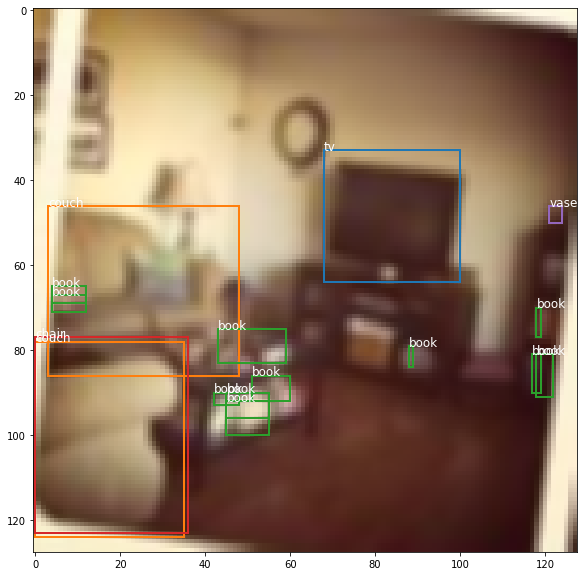

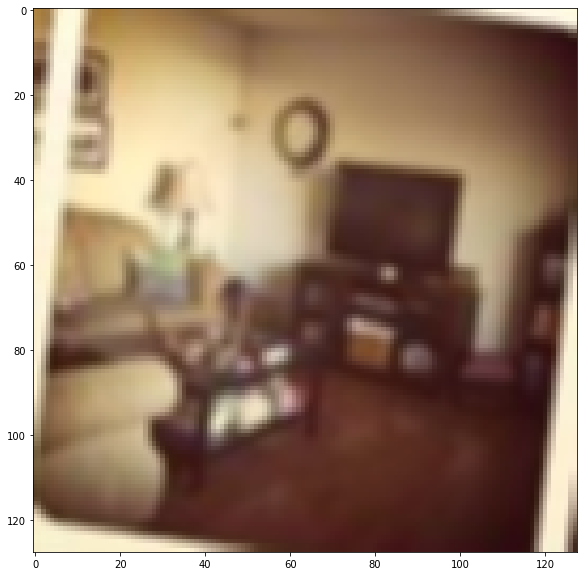

In [ ]:
if torch.cuda.is_available():
    x, y = dataset[best_img_pos] 
    pimg = torchvision.transforms.ToPILImage()(x)
    tgt_l2bs = defaultdict(empty_list)
    for l, b in zip(list(y['labels']), y['boxes']):
        tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

    overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

    frcnn_model.eval()
    pred = frcnn_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0], cutoff=0.5)
    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

Compare with Original Image before transformations incl. Normalization and Resize.

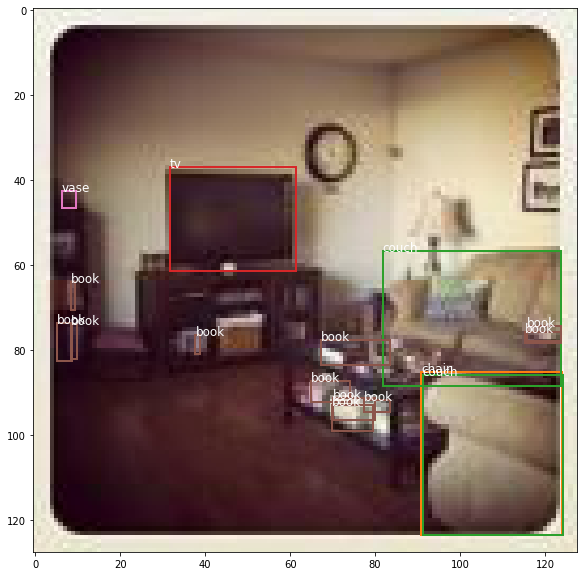

In [ ]:
if torch.cuda.is_available():
    img_id = int(y['image_id'])
    img = Image.open(Path(img_dir)/stats.img2fname[img_id])
    overlay_img_bbox(img, stats.img2l2bs[img_id], stats.lbl2name)

## Reloading Saved Checkpoint using Pytorch Lightning

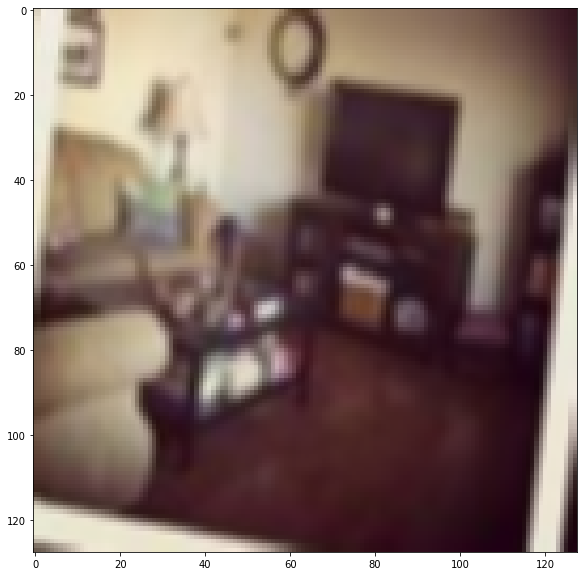

In [ ]:
#hide
if torch.cuda.is_available():
    pretrained_model = FRCNN.load_from_checkpoint(last_model_path, lbl2name=stats.lbl2name)
    pretrained_model.freeze()
    x, y = dataset[best_img_pos] 
    pred = pretrained_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0])
    pimg = torchvision.transforms.ToPILImage()(x)
    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

## Saving and Reloading using Underlying Pytorch

In [ ]:
# export
def save_final(frcnn_model, model_save_path):
    torch.save(frcnn_model.model.state_dict(), model_save_path)

In [ ]:
if torch.cuda.is_available():
    model_save_path = 'models/FRCNN-final.pth'
    save_final(frcnn_model, model_save_path)
    pretrained_model = FRCNN(lbl2name=stats.lbl2name)
    pretrained_model.model.load_state_dict(torch.load(model_save_path))
    pretrained_model.freeze()

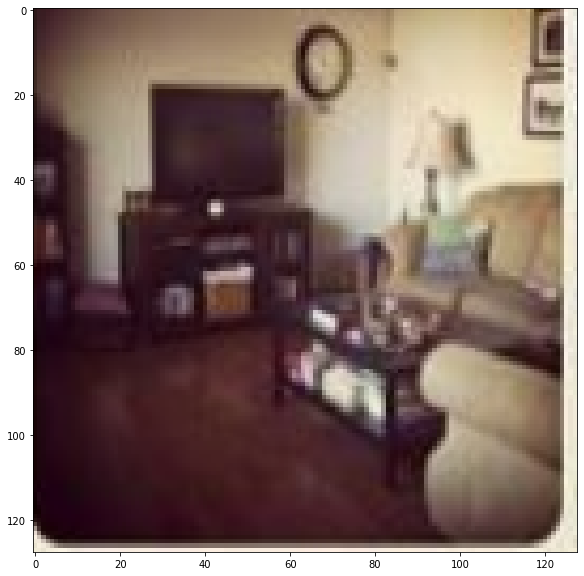

In [ ]:
if torch.cuda.is_available():
    x, y = dataset[best_img_pos] 
    pred = pretrained_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0])
    pimg = torchvision.transforms.ToPILImage()(x)

    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)